# final work - machine learning

#### submitted by: yair giladi: 327511176, noam farhi: 215485598

## NOTE: you can just import all the libraries, and then skip over right to "Find nearest words". you don't have to run it all, if you will use the embedding provided.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd 
from typing import List, Dict, Tuple
import string
import nltk
from nltk.corpus import stopwords
from collections import Counter, defaultdict
import numpy as np
from numpy.linalg import norm
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

2024-10-16 13:22:18.543459: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 13:22:18.653921: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 13:22:18.743660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 13:22:18.827532: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 13:22:18.850878: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 13:22:18.993938: I tensorflow/core/platform/cpu_feature_gu

In [4]:
path_to_data = "/home/yair/Documents/Bar-Ilan/third-year/semester2/applied-machine-learning/Instructions/review_230k.parquet"
data = pd.read_parquet(path_to_data)

In [5]:
def create_dataset(data: pd.DataFrame) -> List[List[str]]:
    """Create the dataset as a list of lists of words."""
    sentences = data['title'].tolist() + data['text'].tolist()
    return [sentence.split() for sentence in sentences]


In [6]:
dataset = create_dataset(data)

In [7]:
dataset[1:5]

[['My', 'home', 'away', 'from', 'home!'],
 ['Great', 'Stay'],
 ['Modern', 'Convenience'],
 ['Its', 'the', 'best', 'of', 'the', 'Andaz', 'Brand', 'in', 'the', 'US....']]

### removing punctuation and converting words to lowercase

In [8]:
def clean_dataset(sentences: List[List[str]]) -> List[List[str]]:
    """Clean the dataset by removing punctuation and converting words to lowercase."""
    translator = str.maketrans('', '', string.punctuation)  # Translator to remove punctuation
    clean_sentences = []

    for sentence in sentences:
        clean_sentence = [word.translate(translator).lower() for word in sentence if word]  # Clean and lowercase words
        clean_sentences.append(clean_sentence)
    
    return clean_sentences

dataset = clean_dataset(dataset)

### Removing all words that are not in english

In [9]:
nltk.download('words')

words = set(nltk.corpus.words.words())

def filter_non_english_words(dataset: List[List[str]]) -> List[List[str]]:
    """Filter non eglish words from the dataset, replacing with <pad>."""
    for i, sentence in enumerate(dataset):
        filtered_sentence = [word if word.lower() in words or not word.isalpha() else "<pad>" for word in sentence]
        dataset[i] = filtered_sentence  # Store the updated sentence back into the dataset

    return dataset

dataset = filter_non_english_words(dataset)

[nltk_data] Downloading package words to /home/yair/nltk_data...
[nltk_data]   Package words is already up-to-date!


### removing stopwords

In [12]:
nltk.download('stopwords')

def replace_stopwords_with_pad(sentences: List[List[str]]) -> List[List[str]]:
    """Replace stopwords with the <pad> token."""
    stops = set(stopwords.words("english"))
    
    clean_sentences = []
    for sentence in sentences:
        clean_sentence = [word if word.lower() not in stops else "<pad>" for word in sentence]
        clean_sentences.append(clean_sentence)
    
    return clean_sentences

dataset = replace_stopwords_with_pad(dataset)

[nltk_data] Downloading package stopwords to /home/yair/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### removing words that appear less then 10 times

In [13]:
def remove_rare_words(dataset: List[List[str]], min_count: int = 10) -> List[List[str]]:
    """Remove words that appear less than `min_count` times from the dataset."""
    
    # Flatten the dataset to count word frequencies
    word_counts = Counter(word for sentence in dataset for word in sentence)
    
    # Filter sentences, keeping only words that appear at least `min_count` times
    filtered_dataset = [
        [word for word in sentence if word_counts[word] >= min_count]
        for sentence in dataset
    ]
    
    return filtered_dataset
    
dataset = remove_rare_words(dataset)

### creating vocabulary

In [14]:
def create_vocabulary(dataset: List[List[str]], max_words: int = 10000) -> Dict[str, int]:
    """Create a dictionary mapping each word to a unique integer, with more frequent words getting lower numbers."""
    word_freq = defaultdict(int)  # Initialize a dictionary to hold word frequencies
    
    # Count the frequency of each word in the dataset
    for sentence in dataset:
        for word in sentence:            
            word_freq[word] += 1  # Increment the word frequency

    # Sort words by frequency (descending) and create a mapping to unique integers
    limited_vocab = {word: idx for idx, (word, _) in enumerate(sorted(word_freq.items(), key=lambda item: item[1], reverse=True)[:max_words])}

    return limited_vocab

vocabulary = create_vocabulary(dataset)
print(len(vocabulary))  # This will print the number of unique words
vocabulary["hotel"]

10000


1

### removing all words that are not in the vocabulary (since I kept it under 100000)

In [15]:
def pad_unknown_words(dataset: List[List[str]], vocabulary: Dict[str, int]) -> List[List[str]]:
    """Replace words not in the vocabulary with <pad>."""
    padded_dataset = []
    
    for sentence in dataset:
        # Replace words not in vocabulary with <pad>
        padded_sentence = [word if word in vocabulary else '<pad>' for word in sentence]
        padded_dataset.append(padded_sentence)
    
    return padded_dataset


dataset = pad_unknown_words(dataset, vocabulary)

### encoding the dataset

In [17]:
def convert_to_sequences(sentences: List[List[str]], 
                         vocabulary: Dict[str, int], 
                         max_length: int = 50) -> np.ndarray:
    """
    Convert a list of sentences into sequences of word indices based on a vocabulary
    
    """
    
    # Create an empty list to hold the sequences
    sequences = []
    
    # Convert each sentence to a sequence of indices
    for sentence in sentences:
        sequence = [vocabulary.get(word, 0) for word in sentence]  # Use 0 for words not in vocabulary
        # Pad the sequence to ensure it has a fixed length
        padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(
            [sequence], maxlen=max_length, padding='post', truncating='post'
        )
        sequences.append(padded_sequence[0])  # Extract the first (and only) sequence

    return np.array(sequences)


sequences = convert_to_sequences(dataset, vocabulary)

In [18]:
sequences[1]

array([  0, 227,  75,   0, 227,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

### generate training data

In [19]:
def generate_training_data(sequences: List[np.ndarray], 
                           window_size: int, 
                           num_ns: int, 
                           vocab_size: int, 
                           seed: int) 
  
   
    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for `vocab_size` tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(len(vocabulary))

    # Iterate over all sequences (sentences) in the dataset.
    for sequence in tqdm.tqdm(sequences):
        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
              sequence,
              vocabulary_size=vocab_size,
              sampling_table=sampling_table,
              window_size=window_size,
              negative_samples=0)

        # Iterate over each positive skip-gram pair to produce training examples
        # with a positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(
                tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size,
                seed=seed,
                name="negative_sampling")

            # Build context and label vectors (for one target word)
            context = tf.concat([tf.squeeze(context_class, 1), negative_sampling_candidates], 0)
            label = tf.constant([1] + [0] * num_ns, dtype="int64")

            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

### Get training targets

In [20]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=5, # I found out that 5 give us a good result, without taking to much time to process.
    num_ns=5,
    vocab_size=len(vocabulary),
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")


100%|█████████████████████████████████| 460678/460678 [05:53<00:00, 1301.73it/s]




targets.shape: (2412422,)
contexts.shape: (2412422, 6)
labels.shape: (2412422, 6)


### Getting ready to train model, setting up improvments.

In [21]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

### define the model

In [22]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy)
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots


### setting up parameters and compiling the model

In [23]:
def custom_loss(x_logit: tf.Tensor, y_true: tf.Tensor) -> tf.Tensor:
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)
    the
embedding_dim = 200 #This dimention worked fine for me
word2vec = Word2Vec(len(vocabulary), embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

### Training the model

In [ ]:
word2vec.fit(dataset, epochs=10)

Epoch 1/10
1548/2355 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.3747 - loss: 1.5678

### Save embeddingg to parquet file

In [23]:
# Get the embedding matrix from the target_embedding layer
embedding_matrix = word2vec.target_embedding.get_weights()[0]

# Create a DataFrame with words and their embeddings
embedding_df = pd.DataFrame(embedding_matrix)
embedding_df['word'] = [word for word, idx in sorted(vocabulary.items(), key=lambda item: item[1])]

# Reorder columns so 'word' comes first
embedding_df = embedding_df[['word'] + list(embedding_df.columns[:-1])]

# Save the DataFrame to a Parquet file
embedding_df.to_parquet('word2vec_embeddings_final.parquet', index=False)

print("Embeddings saved to Parquet format.")


Embeddings saved to Parquet format.


### Find nearest words

In [3]:
# Load the Parquet file into a DataFrame
path_to_embedding = 'word2vec_embeddings_final.parquet' # Insert your path here
embedding_df = pd.read_parquet(path_to_embedding)

# Convert the embedding DataFrame to a numpy array for similarity computation
embedding_matrix = embedding_df.drop(columns=['word']).to_numpy()

# Create a vocabulary mapping from words to indices
vocabulary = {word: idx for idx, word in enumerate(embedding_df['word'].tolist())}

# Create a reverse vocabulary to map indices back to words
reverse_vocabulary = {idx: word for word, idx in vocabulary.items()}

def find_nearest_words(word: str, k: int, embedding_matrix: np.ndarray, vocabulary: Dict[str, int]) -> List[str]:
    """Find the nearest k words to a given word based on cosine similarity."""
    if word not in vocabulary:
        return [f"'{word}' not in vocabulary."]
    
    # Get the embedding for the target word
    word_idx = vocabulary[word]
    word_embedding = embedding_matrix[word_idx]
    
    # Compute cosine similarity between the target word and all other words
    similarities = np.dot(embedding_matrix, word_embedding) / (norm(embedding_matrix, axis=1) * norm(word_embedding))

    # Get the indices of the k most similar words (excluding the word itself)
    nearest_indices = np.argsort(similarities)[-k-1:-1][::-1]  # Exclude the word itself

    # Map the indices back to words
    nearest_words = [reverse_vocabulary[idx] for idx in nearest_indices]
    
    return nearest_words

nearest_words = find_nearest_words('view', 5, embedding_matriapartmentx, vocabulary)
print(nearest_words)


['facing', 'river', 'floor', 'harbour', 'panoramic']


### Using pca to plot the words

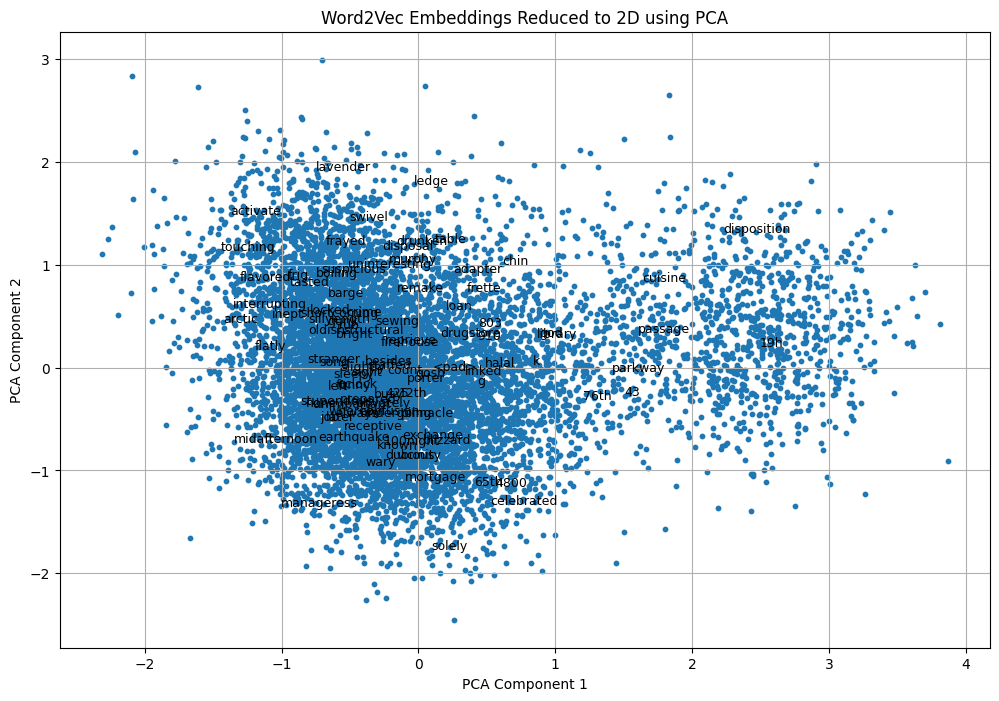

In [4]:
# Extract the words and their corresponding embeddings
words = embedding_df['word'].values
embedding_matrix = embedding_df.drop(columns=['word']).to_numpy()

# Apply PCA to reduce embeddings to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_matrix)

# Plot the reduced embeddings
plt.figure(figsize=(12, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=10)

# Annotate some points with their words
for i, word in enumerate(words):
    if i % 100 == 0:  # Annotate every 100th word for clarity, can adjust as needed
        plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=9)

plt.title('Word2Vec Embeddings Reduced to 2D using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()


### implementing k-means


K-Means Clustering with 5 clusters:

Cluster 1: de, la, e, un, en, di, con, non, pour, che ...
Cluster 2: bed, bathroom, floor, door, shower, coffee, noise, water, sleep, space ...
Cluster 3: hotel, , stay, new, stayed, one, time, times, square, york ...
Cluster 4: <pad>, room, great, location, staff, good, clean, nice, service, small ...
Cluster 5: would, us, helpful, could, desk, front, even, go, didnt, check ...


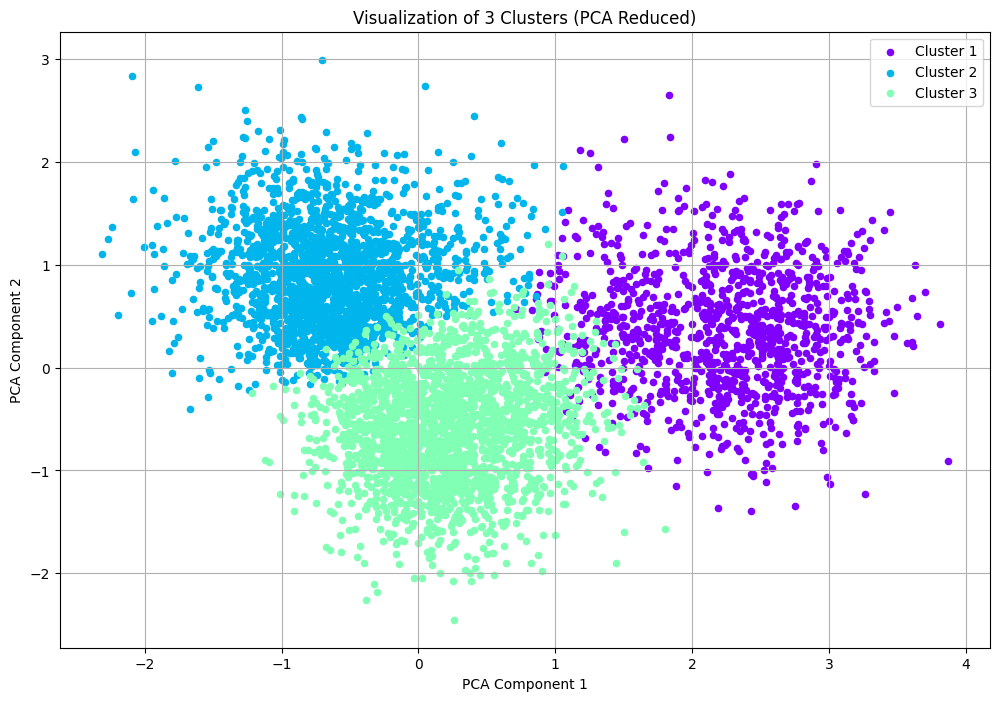

In [34]:
def kmeans_clustering(embedding_matrix, words, k=5, n_clusters_to_plot=5):
    """
    Perform K-means clustering on word embeddings, print some clusters, and plot specified number of clusters.
    
    Args:
        embedding_matrix (np.ndarray): Word embedding vectors.
        words (np.ndarray): Array of words corresponding to embeddings.
        k (int): Number of clusters.
        n_clusters_to_plot (int): Number of clusters to visualize.
    """
    
    # Step 1: Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(embedding_matrix)

    # Step 2: Print some sample clusters
    print(f"\nK-Means Clustering with {k} clusters:\n")
    for cluster_id in range(min(k, 5)):  # Print first few clusters
        cluster_words = words[cluster_labels == cluster_id]
        print(f"Cluster {cluster_id + 1}: {', '.join(cluster_words[:10])} ...")  # Print first 10 words from each cluster

    # Step 3: Apply PCA to reduce to 2D for plotting
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embedding_matrix)

    # Step 4: Plot the clusters (only `n_clusters_to_plot` will be shown)
    plt.figure(figsize=(12, 8))
    colors = plt.cm.rainbow(np.linspace(0, 1, k))  # Generate distinct colors for clusters
    
    for cluster_id in range(min(k, n_clusters_to_plot)):
        cluster_points = reduced_embeddings[cluster_labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=20, color=colors[cluster_id], label=f"Cluster {cluster_id + 1}")
    
    plt.title(f'Visualization of {n_clusters_to_plot} Clusters (PCA Reduced)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()


k = 5  # Set the number of clusters
n_clusters_to_plot = 3  # Set the number of clusters to plot

# Perform clustering and plot
kmeans_clustering(embedding_matrix, words, k=k, n_clusters_to_plot=n_clusters_to_plot)


### If we look at the cluster, we can see some interesting patters. the first cluster seems to be made out of "stopwords" that I failed to remove because they are not in english (though they are considered "english" in some sense, hence why they weren't removed before)

### The second seems to be made out of aspects of apartment. 

### The Third consists of vacation related words.

### The fourth lookes like reviews the hotel received.

### the fifth seems like it is made from request people made, possibly at the reception.

## If you want, you can run the function again with different parameters, and what other interesting clusters we could find.

# Thank you for reading!